#  AT82.05 Artificial Intelligence: Natural Language Understanding (NLU)

## A6: Let's Talk With Yourselves

### Name: Arya Shah
### StudentID: st125462

-----------

In this assignment, I will be apply RAG (Retrieval-Augmented Generation) techniques in Langchain framework and from scratch to augment my chatbot that specializes in answering questions related to myself, my documents, resume, and any other relevant information

You can find the GitHub Repository for the assignment here:
- https://github.com/aryashah2k/NLP-NLU (Complete Web App)
- https://github.com/aryashah2k/NLP-NLU/tree/main/notebooks (Assignment Notebooks)
- https://github.com/aryashah2k/NLP-NLU/tree/main/reports (Assignment Reports)

# Task 1. Source Discovery ✅

Based on code-along/01-rag-langchain.ipynb, modify as follows:

1) Find all relevant sources related to yourself, including documents, websites, or personal data. Please list down the reference documents (1 point) ✅
2) Design your Prompt for Chatbot to handle questions related to your personal information. Develop a model that can provide gentle and informative answers based on the designed template. (0.5 point) ✅
3) Explore the use of other text-generation models or OPENAI models to enhance AI capabilities. (0.5 point) ✅
Note: Groq also offers the llama3-70b model (generator model) with limited request capacity

Here are all the relevant sources related to me that I ended up using:
1. Prepared my resume in a structured format, can be found under `a6_talk_with_yourselves` folder
2. Prepared a series of blog posts on common aspects, personal life, studies, and things in general, can be found under `a6_talk_with_yourselves` folder
3. Prepared a personal information document holding my biodata, referred my LinkedIn, GitHub, Kaggle Profiles to gather information in one place, can be found under `a6_talk_with_yourselves` folder

Web Sources: 

LinkedIn(For Professional Experience and Education): https://www.linkedin.com/in/arya--shah/
Twitter/X(For Ideologies): https://x.com/aryashah2k
GitHub(For Projects): https://github.com/aryashah2k
Kaggle(For Projects and Research Interests): https://www.kaggle.com/aryashah2k

I designed the following short/simple promptfor chatbot to handle questions related to my personal information:

```python
prompt = f"""
        I am a helpful assistant that provides accurate information about Arya Shah based on the provided context.
        I will answer questions about Arya's personal information, education, work experience, skills, beliefs, and other relevant details.
        I will be friendly, conversational, and informative in my responses.
        If I don't know the answer based on the provided context, I will say so honestly rather than making up information.
        
        Context:
        {context}
        
        Question: {question}
        
        Answer:
        """
```

I have made use of other text generation models such as:

- **Language Model**: `google/flan-t5-base`
- **Configuration**: 
  - Temperature: 0.1 (for more factual responses)
  - Repetition Penalty: 1.2 (to avoid repetitive text)
  - Max New Tokens: 512

Apart from the existing ones present in the Code Along Scripts such as:

- BAAI/bge-small-en-v1.5
- Llama-3.2-1B-Instruct

# `RAG Script using Langchain`

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # Personal Information RAG Chatbot
# 
# This script implements a Retrieval-Augmented Generation (RAG) chatbot
# that specializes in answering questions about personal information.

import os
import torch
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import RetrievalQA
from langchain.chains import LLMChain
from transformers import AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
from langchain.llms import HuggingFacePipeline

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create vector store directory if it doesn't exist
vector_path = './vector-store'
if not os.path.exists(vector_path):
    os.makedirs(vector_path)
    print('Vector store directory created')

# 1. Document Loaders - Load personal information from various sources
def load_documents():
    """Load personal information documents"""
    sources = [
        './personal_info.txt',
        './resume.txt',
        './blog_posts.txt'
    ]
    
    all_documents = []
    for source in sources:
        loader = TextLoader(source)
        documents = loader.load()
        all_documents.extend(documents)
        print(f"Loaded {len(documents)} documents from {source}")
    
    return all_documents

# 2. Document Transformers - Split documents into chunks
def split_documents(documents):
    """Split documents into manageable chunks"""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=100
    )
    
    doc_chunks = text_splitter.split_documents(documents)
    print(f"Created {len(doc_chunks)} document chunks")
    
    return doc_chunks

# 3. Text Embedding Models - Create embeddings for document chunks
def initialize_embedding_model():
    """Initialize the embedding model"""
    model_name = 'sentence-transformers/all-mpnet-base-v2'  # Using a simpler model
    
    embedding_model = HuggingFaceEmbeddings(
        model_name=model_name
    )
    
    print(f"Initialized embedding model: {model_name}")
    return embedding_model

# 4. Vector Stores - Create or load vector store
def setup_vector_store(doc_chunks, embedding_model):
    """Set up vector store for document retrieval"""
    db_file_name = 'personal_info_db'
    
    # Check if vector store already exists
    if os.path.exists(os.path.join(vector_path, db_file_name)):
        print("Loading existing vector store...")
        vectordb = FAISS.load_local(
            folder_path=os.path.join(vector_path, db_file_name),
            embeddings=embedding_model
        )
    else:
        print("Creating new vector store...")
        vectordb = FAISS.from_documents(
            documents=doc_chunks,
            embedding=embedding_model
        )
        
        # Save vector store locally
        vectordb.save_local(
            folder_path=os.path.join(vector_path, db_file_name)
        )
    
    return vectordb

# 5. LLM Setup - Initialize language model for generation
def setup_llm():
    """Set up the language model for generation"""
    # Using Flan-T5 model for generation
    model_id = "google/flan-t5-base"  # Smaller model for faster loading
    
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        model_id,
        device_map='auto',
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    
    pipe = pipeline(
        task="text2text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        model_kwargs={
            "temperature": 0.1,
            "repetition_penalty": 1.2
        }
    )
    
    llm = HuggingFacePipeline(pipeline=pipe)
    print(f"Initialized language model: {model_id}")
    
    return llm

# 6. Prompt Template - Create custom prompt for personal information
def create_prompt_template():
    """Create a custom prompt template for personal information"""
    prompt_template = """
    I am a helpful assistant that provides accurate information about John Smith based on the provided context.
    I will answer questions about John's personal information, education, work experience, skills, beliefs, and other relevant details.
    I will be friendly, conversational, and informative in my responses.
    If I don't know the answer based on the provided context, I will say so honestly rather than making up information.
    
    Context:
    {context}
    
    Question: {question}
    
    Answer:
    """.strip()
    
    # Use the older format for creating PromptTemplate with langchain 0.0.27
    prompt = PromptTemplate(
        input_variables=["context", "question"],
        template=prompt_template
    )
    print("Created custom prompt template")
    
    return prompt

# 7. RAG Chain - Set up the retrieval-augmented generation chain
def setup_rag_chain(vectordb, llm, prompt):
    """Set up the RAG chain for question answering"""
    # Create retriever
    retriever = vectordb.as_retriever(
        search_kwargs={"k": 3}  # Retrieve top 3 most relevant chunks
    )
    
    # Create memory
    memory = ConversationBufferMemory(
        memory_key="chat_history",
        input_key="question",
        output_key="answer"
    )
    
    # Create QA chain with older langchain 0.0.27 format
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={"prompt": prompt}
    )
    
    print("RAG chain setup complete")
    return qa_chain

# 8. Query Function - Function to query the RAG chain
def query_rag_chain(chain, question):
    """Query the RAG chain with a question"""
    # Adjusted for langchain 0.0.27 format
    result = chain({"query": question})
    
    # In older langchain, the result key might be different
    answer = result.get('result', '')
    source_docs = result.get('source_documents', [])
    
    # Format source information
    sources = []
    for doc in source_docs:
        source = {
            "content": doc.page_content[:150] + "...",  # Truncate for display
            "source": doc.metadata.get('source', 'Unknown')
        }
        sources.append(source)
    
    return {
        "question": question,
        "answer": answer,
        "sources": sources
    }

# Main function to initialize and return the RAG chain
def initialize_rag_system():
    """Initialize the complete RAG system"""
    print("Initializing RAG system...")
    
    # Load and process documents
    documents = load_documents()
    doc_chunks = split_documents(documents)
    
    # Set up embedding model and vector store
    embedding_model = initialize_embedding_model()
    vectordb = setup_vector_store(doc_chunks, embedding_model)
    
    # Set up LLM and prompt
    llm = setup_llm()
    prompt = create_prompt_template()
    
    # Set up RAG chain
    chain = setup_rag_chain(vectordb, llm, prompt)
    
    print("RAG system initialization complete")
    return chain

# If run directly, test the RAG system
if __name__ == "__main__":
    # Initialize the RAG system
    chain = initialize_rag_system()
    
    # Test with a few questions
    test_questions = [
        "How old are you?",
        "What is your highest level of education?",
        "What are your core beliefs regarding technology?"
    ]
    
    print("\nTesting RAG system with sample questions:")
    for question in test_questions:
        print(f"\nQuestion: {question}")
        result = query_rag_chain(chain, question)
        print(f"Answer: {result['answer']}")
        print("Sources:")
        for source in result['sources']:
            print(f" - {source['source']}")


# `Simple RAG from Scratch`

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # Simple Personal Information RAG Chatbot
# 
# This script implements a Retrieval-Augmented Generation (RAG) chatbot
# that specializes in answering questions about personal information.
# It uses a simplified approach without relying on LangChain.

import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel, pipeline, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import pickle
import json

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create vector store directory if it doesn't exist
vector_path = './vector-store'
if not os.path.exists(vector_path):
    os.makedirs(vector_path)
    print('Vector store directory created')

# 1. Document Loaders - Load personal information from various sources
def load_documents():
    """Load personal information documents"""
    sources = [
        './personal_info.txt',
        './resume.txt',
        './blog_posts.txt'
    ]
    
    all_documents = []
    for source in sources:
        try:
            with open(source, 'r', encoding='utf-8') as file:
                content = file.read()
                all_documents.append({
                    'content': content,
                    'source': source
                })
            print(f"Loaded document from {source}")
        except Exception as e:
            print(f"Error loading {source}: {e}")
    
    return all_documents

# 2. Document Transformers - Split documents into chunks
def split_documents(documents, chunk_size=500, chunk_overlap=100):
    """Split documents into manageable chunks"""
    doc_chunks = []
    
    for doc in documents:
        content = doc['content']
        source = doc['source']
        
        # Simple text splitting by paragraphs first, then by chunk size
        paragraphs = content.split('\n\n')
        
        for para in paragraphs:
            if not para.strip():
                continue
                
            # If paragraph is smaller than chunk size, keep it as is
            if len(para) <= chunk_size:
                doc_chunks.append({
                    'content': para,
                    'source': source
                })
            else:
                # Split large paragraphs into overlapping chunks
                for i in range(0, len(para), chunk_size - chunk_overlap):
                    chunk = para[i:i + chunk_size]
                    if len(chunk) >= 50:  # Only keep chunks with substantial content
                        doc_chunks.append({
                            'content': chunk,
                            'source': source
                        })
    
    print(f"Created {len(doc_chunks)} document chunks")
    return doc_chunks

# 3. Text Embedding Models - Create embeddings for document chunks
class SentenceEmbedder:
    def __init__(self, model_name='sentence-transformers/all-mpnet-base-v2'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        print(f"Initialized embedding model: {model_name}")
        
    def get_embeddings(self, texts):
        """Get embeddings for a list of texts"""
        embeddings = []
        
        for text in texts:
            # Tokenize and prepare input
            inputs = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
            
            # Get embeddings
            with torch.no_grad():
                outputs = self.model(**inputs)
                
            # Use mean pooling to get sentence embedding
            attention_mask = inputs['attention_mask']
            token_embeddings = outputs.last_hidden_state
            
            # Mask padding tokens
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            embedding = (sum_embeddings / sum_mask).squeeze(0).cpu().numpy()
            
            embeddings.append(embedding)
            
        return np.array(embeddings)

# 4. Vector Stores - Create or load vector store
class FAISSVectorStore:
    def __init__(self, embedding_model):
        self.embedding_model = embedding_model
        self.index = None
        self.documents = []
        
    def add_documents(self, documents):
        """Add documents to the vector store"""
        self.documents = documents
        
        # Extract text content for embedding
        texts = [doc['content'] for doc in documents]
        
        # Get embeddings
        embeddings = self.embedding_model.get_embeddings(texts)
        
        # Create FAISS index
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        
        # Add embeddings to index
        self.index.add(embeddings.astype(np.float32))
        
        print(f"Added {len(documents)} documents to vector store")
        
    def similarity_search(self, query, k=3):
        """Search for similar documents"""
        # Get query embedding
        query_embedding = self.embedding_model.get_embeddings([query])[0].reshape(1, -1)
        
        # Search in FAISS index
        distances, indices = self.index.search(query_embedding.astype(np.float32), k)
        
        # Get relevant documents
        results = []
        for i, idx in enumerate(indices[0]):
            if idx < len(self.documents):
                doc = self.documents[idx]
                results.append({
                    'content': doc['content'],
                    'source': doc['source'],
                    'score': float(distances[0][i])
                })
        
        return results
    
    def save(self, path):
        """Save vector store to disk"""
        os.makedirs(path, exist_ok=True)
        
        # Save FAISS index
        faiss.write_index(self.index, os.path.join(path, 'index.faiss'))
        
        # Save documents
        with open(os.path.join(path, 'documents.pkl'), 'wb') as f:
            pickle.dump(self.documents, f)
            
        print(f"Saved vector store to {path}")
        
    def load(self, path):
        """Load vector store from disk"""
        # Load FAISS index
        self.index = faiss.read_index(os.path.join(path, 'index.faiss'))
        
        # Load documents
        with open(os.path.join(path, 'documents.pkl'), 'rb') as f:
            self.documents = pickle.load(f)
            
        print(f"Loaded vector store from {path} with {len(self.documents)} documents")
        return self

# 5. LLM Setup - Initialize language model for generation
class TextGenerator:
    def __init__(self, model_id='google/flan-t5-base'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(
            model_id,
            device_map='auto',
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
        )
        
        self.pipe = pipeline(
            task="text2text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            max_new_tokens=512,
            model_kwargs={
                "temperature": 0.1,
                "repetition_penalty": 1.2
            }
        )
        
        print(f"Initialized language model: {model_id}")
        
    def generate(self, prompt):
        """Generate text based on prompt"""
        result = self.pipe(prompt)
        return result[0]['generated_text']

# 6. RAG System - Combine retrieval and generation
class RAGSystem:
    def __init__(self, vector_store, generator):
        self.vector_store = vector_store
        self.generator = generator
        self.chat_history = []
        
    def query(self, question):
        """Process a query through the RAG system"""
        # Retrieve relevant documents
        results = self.vector_store.similarity_search(question)
        
        # Format context for the generator
        context = "\n\n".join([f"From {r['source']}:\n{r['content']}" for r in results])
        
        # Create prompt
        prompt = f"""
        I am a helpful assistant that provides accurate information about Arya Shah based on the provided context.
        I will answer questions about Arya's personal information, education, work experience, skills, beliefs, and other relevant details.
        I will be friendly, conversational, and informative in my responses.
        If I don't know the answer based on the provided context, I will say so honestly rather than making up information.
        
        Context:
        {context}
        
        Question: {question}
        
        Answer:
        """.strip()
        
        # Generate answer
        answer = self.generator.generate(prompt)
        
        # Update chat history
        self.chat_history.append({
            "question": question,
            "answer": answer
        })
        
        return {
            "question": question,
            "answer": answer,
            "sources": results
        }
    
    def save_chat_history(self, filename='qa_history.json'):
        """Save chat history to a JSON file"""
        with open(filename, 'w') as f:
            json.dump(self.chat_history, f, indent=2)
        print(f"Saved chat history to {filename}")

# Main function to initialize and return the RAG system
def initialize_rag_system():
    """Initialize the complete RAG system"""
    print("Initializing RAG system...")
    
    # Set up paths
    vector_store_path = os.path.join(vector_path, 'personal_info_db')
    
    # Initialize embedding model
    embedder = SentenceEmbedder()
    
    # Initialize vector store
    vector_store = FAISSVectorStore(embedder)
    
    # Check if vector store exists
    if os.path.exists(os.path.join(vector_store_path, 'index.faiss')):
        print("Loading existing vector store...")
        vector_store.load(vector_store_path)
    else:
        print("Creating new vector store...")
        # Load and process documents
        documents = load_documents()
        doc_chunks = split_documents(documents)
        
        # Add documents to vector store
        vector_store.add_documents(doc_chunks)
        
        # Save vector store
        vector_store.save(vector_store_path)
    
    # Initialize text generator
    generator = TextGenerator()
    
    # Create RAG system
    rag_system = RAGSystem(vector_store, generator)
    
    print("RAG system initialization complete")
    return rag_system

# If run directly, test the RAG system
if __name__ == "__main__":
    # Initialize the RAG system
    rag = initialize_rag_system()
    
    # Test with a few questions
    test_questions = [
        "How old are you?",
        "What is your highest level of education?",
        "What are your core beliefs regarding technology?"
    ]
    
    print("\nTesting RAG system with sample questions:")
    for question in test_questions:
        print(f"\nQuestion: {question}")
        result = rag.query(question)
        print(f"Answer: {result['answer']}")
        print("Sources:")
        for source in result['sources']:
            print(f" - {source['source']}")


# Analysis of Both Scripts:

| Feature | personal_rag.py | simple_rag.py |
|---------|----------------|---------------|
| **Framework** | Uses LangChain for RAG implementation | Custom implementation without LangChain dependency |
| **Architecture** | Structured around LangChain components (document loaders, text splitters, embeddings, vector stores) | Implements similar components but with custom classes |
| **Embedding Model** | Uses HuggingFaceEmbeddings with 'sentence-transformers/all-mpnet-base-v2' | Custom SentenceEmbedder class using the same model |
| **Vector Store** | Uses FAISS through LangChain's wrapper | Direct implementation with FAISS library |
| **LLM** | Uses HuggingFacePipeline with 'google/flan-t5-base' | Custom TextGenerator class with the same model |
| **Document Processing** | Uses RecursiveCharacterTextSplitter | Custom splitting function with similar parameters |
| **Memory** | Includes ConversationBufferMemory for chat history | Maintains chat history in a simple list structure |
| **Prompt Template** | Uses LangChain's PromptTemplate | Hardcoded prompt string in the query method |
| **Chain Type** | Uses RetrievalQA with "stuff" chain type | Custom implementation combining retrieval and generation |
| **Persona** | References "John Smith" in prompt | References "Arya Shah" in prompt |
| **Persistence** | Saves vector store only | Saves both vector store and chat history |

Both scripts implement Retrieval-Augmented Generation (RAG) systems for answering questions about personal information, but with different approaches to the implementation architecture.

# Task 2. Analysis and Problem Solving ✅

1) Provide a list of the retriever and generator models you have utilized. (0.25 point) ✅
2) Analyze any issues related to the models providing unrelated information. (0.25 point) ✅

Note: RAG utilizes two models: a retriever model and a generator model. Therefore, when performing your analysis, make sure to evaluate and analyze both models, not just one.

## Retriever and Generator Models Utilized

### Retriever Models
- **HuggingFaceEmbeddings** with 'sentence-transformers/all-mpnet-base-v2' model in personal_rag.py
- Custom **SentenceEmbedder** class (also using 'sentence-transformers/all-mpnet-base-v2') in simple_rag.py
- Both scripts use **FAISS** as the vector database for storing and retrieving document embeddings

### Generator Models
- **HuggingFacePipeline** with 'google/flan-t5-base' model in personal_rag.py
- Custom **TextGenerator** class (also using 'google/flan-t5-base') in simple_rag.py

## Issues Related to Models Providing Unrelated Information

### Retriever Model Issues
- **Suboptimal retrieval performance**: The retriever might fail to rank the most relevant documents highly enough, causing less useful content to dominate the results
- **Irrelevant document retrieval**: When the retrieval component selects outdated or irrelevant documents, the generator may produce answers based on incorrect information
- **Missing content in knowledge base**: If relevant information isn't available in the indexed documents, the system may provide incorrect answers
- **Context limitations**: Token limits in LLMs can lead to truncation of essential information when processing large datasets

### Generator Model Issues
- **Integration challenges**: The generator may struggle to effectively use the retrieved documents, leading to coherence issues in responses
- **Format adherence problems**: The generator might ignore instructions about output format (tables, lists, etc.)
- **Difficulty extracting answers**: Even when relevant information is retrieved, the generator may fail to extract it correctly from context that contains noise or conflicting information
- **Overreliance on context**: The generator may be too heavily "grounded" by the retrieved context, limiting its ability to utilize its training knowledge when the answer isn't fully present in the retrieved documents


# `Model Analysis Script`

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # RAG Model Analysis
# 
# This script provides analysis of the retriever and generator models used in our RAG system,
# focusing on issues related to unrelated information and performance evaluation.

import os
import json
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from simple_rag import initialize_rag_system, SentenceEmbedder

def analyze_retriever_model(rag_system, test_questions, verbose=True):
    """
    Analyze the retriever model's performance in finding relevant documents.
    
    Args:
        rag_system: The initialized RAG system
        test_questions: List of test questions
        verbose: Whether to print detailed analysis
        
    Returns:
        Dictionary with analysis results
    """
    if verbose:
        print("\n=== Retriever Model Analysis ===")
        print(f"Model: sentence-transformers/all-mpnet-base-v2")
        print(f"Vector Store: FAISS (Facebook AI Similarity Search)")
    
    # Analyze retrieval performance
    retrieval_scores = []
    irrelevant_retrievals = 0
    total_retrievals = 0
    
    for question in test_questions:
        # Get retrievals without generating answer
        results = rag_system.vector_store.similarity_search(question)
        total_retrievals += len(results)
        
        # Check relevance (simple heuristic - if question keywords appear in content)
        question_keywords = set(question.lower().split())
        question_keywords = {word for word in question_keywords if len(word) > 3}  # Filter out short words
        
        for result in results:
            content = result['content'].lower()
            keyword_matches = sum(1 for keyword in question_keywords if keyword in content)
            relevance_score = keyword_matches / len(question_keywords) if question_keywords else 0
            
            retrieval_scores.append(relevance_score)
            if relevance_score < 0.3:  # Threshold for relevance
                irrelevant_retrievals += 1
    
    avg_relevance = np.mean(retrieval_scores) if retrieval_scores else 0
    irrelevant_percentage = (irrelevant_retrievals / total_retrievals) * 100 if total_retrievals else 0
    
    analysis = {
        "model": "sentence-transformers/all-mpnet-base-v2",
        "vector_store": "FAISS",
        "average_relevance_score": float(avg_relevance),
        "irrelevant_retrievals_percentage": float(irrelevant_percentage),
        "total_retrievals": total_retrievals
    }
    
    if verbose:
        print(f"Average Relevance Score: {avg_relevance:.2f} (0-1 scale)")
        print(f"Irrelevant Retrievals: {irrelevant_percentage:.1f}% ({irrelevant_retrievals}/{total_retrievals})")
        print("\nRetriever Model Issues and Mitigations:")
        print("1. Issue: Semantic misunderstanding - The embedding model may not capture the true semantic meaning of questions")
        print("   Mitigation: Using a more advanced embedding model like all-mpnet-base-v2 which has better semantic understanding")
        print("2. Issue: Lack of context awareness - The retriever doesn't understand the conversation context")
        print("   Mitigation: Could be improved by incorporating conversation history into the retrieval process")
        print("3. Issue: Irrelevant document chunks - Some retrieved chunks may not contain the answer")
        print("   Mitigation: Using smaller chunk sizes with overlap to ensure relevant information isn't split across chunks")
    
    return analysis

def analyze_generator_model(rag_system, test_questions, verbose=True):
    """
    Analyze the generator model's performance in providing accurate and relevant responses.
    
    Args:
        rag_system: The initialized RAG system
        test_questions: List of test questions
        verbose: Whether to print detailed analysis
        
    Returns:
        Dictionary with analysis results
    """
    if verbose:
        print("\n=== Generator Model Analysis ===")
        print(f"Model: google/flan-t5-base")
    
    # Analyze generation performance
    hallucination_count = 0
    total_generations = len(test_questions)
    
    for question in test_questions:
        # Get full response
        result = rag_system.query(question)
        answer = result["answer"]
        sources = result["sources"]
        
        # Check for potential hallucinations (simple heuristic)
        source_content = " ".join([s["content"] for s in sources]).lower()
        
        # Extract key statements from answer (simplistic approach)
        statements = [sent.strip() for sent in answer.split('.') if sent.strip()]
        
        for statement in statements:
            # If a substantial statement doesn't have keywords in the source, it might be a hallucination
            statement_keywords = set(statement.lower().split())
            statement_keywords = {word for word in statement_keywords if len(word) > 4}  # Filter out short words
            
            if statement_keywords:
                matches = sum(1 for keyword in statement_keywords if keyword in source_content)
                if matches / len(statement_keywords) < 0.3:  # Threshold for hallucination detection
                    hallucination_count += 1
                    break
    
    hallucination_percentage = (hallucination_count / total_generations) * 100 if total_generations else 0
    
    analysis = {
        "model": "google/flan-t5-base",
        "total_generations": total_generations,
        "potential_hallucinations": hallucination_count,
        "hallucination_percentage": float(hallucination_percentage)
    }
    
    if verbose:
        print(f"Potential Hallucinations: {hallucination_percentage:.1f}% ({hallucination_count}/{total_generations})")
        print("\nGenerator Model Issues and Mitigations:")
        print("1. Issue: Hallucinations - The model may generate facts not present in the retrieved documents")
        print("   Mitigation: Using a lower temperature (0.1) and explicit instructions to only use provided context")
        print("2. Issue: Verbosity - The model may generate overly verbose responses")
        print("   Mitigation: Using a repetition penalty (1.2) to discourage repetitive text")
        print("3. Issue: Inconsistency - The model may provide different answers to similar questions")
        print("   Mitigation: Could be improved by fine-tuning on domain-specific data")
        print("4. Issue: Limited context window - The model may not utilize all retrieved information effectively")
        print("   Mitigation: Using a 'stuff' approach that combines all retrieved documents into a single context")
    
    return analysis

def analyze_rag_system_performance(test_questions=None, save_results=True):
    """
    Perform comprehensive analysis of the RAG system, including both retriever and generator models.
    
    Args:
        test_questions: List of test questions (if None, uses default questions)
        save_results: Whether to save analysis results to a file
        
    Returns:
        Dictionary with complete analysis results
    """
    print("Initializing RAG system for analysis...")
    rag_system = initialize_rag_system()
    
    if test_questions is None:
        test_questions = [
            "How old are you?",
            "What is your highest level of education?",
            "What are your core beliefs regarding technology?",
            "What programming languages do you know?",
            "Where did you work before Google?",
            "What are your research interests?",
            "What challenges have you faced in your studies?",
            "How do you think about diversity in tech?",
            "What was your role at Microsoft?",
            "What are your academic goals?"
        ]
    
    print(f"\nAnalyzing RAG system performance with {len(test_questions)} test questions...")
    
    # Analyze retriever model
    retriever_analysis = analyze_retriever_model(rag_system, test_questions)
    
    # Analyze generator model
    generator_analysis = analyze_generator_model(rag_system, test_questions)
    
    # Combined analysis
    analysis_results = {
        "retriever_analysis": retriever_analysis,
        "generator_analysis": generator_analysis,
        "test_questions": test_questions,
        "overall_assessment": {
            "retriever_performance": "Good" if retriever_analysis["average_relevance_score"] > 0.6 else "Needs improvement",
            "generator_performance": "Good" if generator_analysis["hallucination_percentage"] < 20 else "Needs improvement"
        }
    }
    
    # Print overall assessment
    print("\n=== Overall RAG System Assessment ===")
    print(f"Retriever Performance: {analysis_results['overall_assessment']['retriever_performance']}")
    print(f"Generator Performance: {analysis_results['overall_assessment']['generator_performance']}")
    
    print("\nRecommendations for Improvement:")
    print("1. Consider using a more advanced embedding model for better semantic understanding")
    print("2. Experiment with different chunk sizes and overlap values for optimal retrieval")
    print("3. Fine-tune the generator model on domain-specific data for more accurate responses")
    print("4. Implement a more sophisticated relevance scoring mechanism for retrieved documents")
    print("5. Add a post-processing step to verify generated content against retrieved documents")
    
    if save_results:
        with open('model_analysis_results.json', 'w') as f:
            json.dump(analysis_results, f, indent=2)
        print("\nAnalysis results saved to model_analysis_results.json")
    
    return analysis_results

if __name__ == "__main__":
    analyze_rag_system_performance()


# Task 3. Chatbot Development - Web Application Development ✅

Develop a web application that demonstrates a chatbot. ✅

1) The application should feature a chat interface with an input box where users can type messages. ✅
2) Based on the user input, the model should generate coherent responses and also provide relevant source documents that support the generated response. For example, if the user types ”How old are you?”, the model might generate a concise summary along with links to related articles or documents. (0.5 point) ✅

Note: You are encouraged to use any available resources related to your personal information, and ensure the chatbot provides accurate and relevant information

# App Screenshots Covering Various Functionalities

### Chat Window:
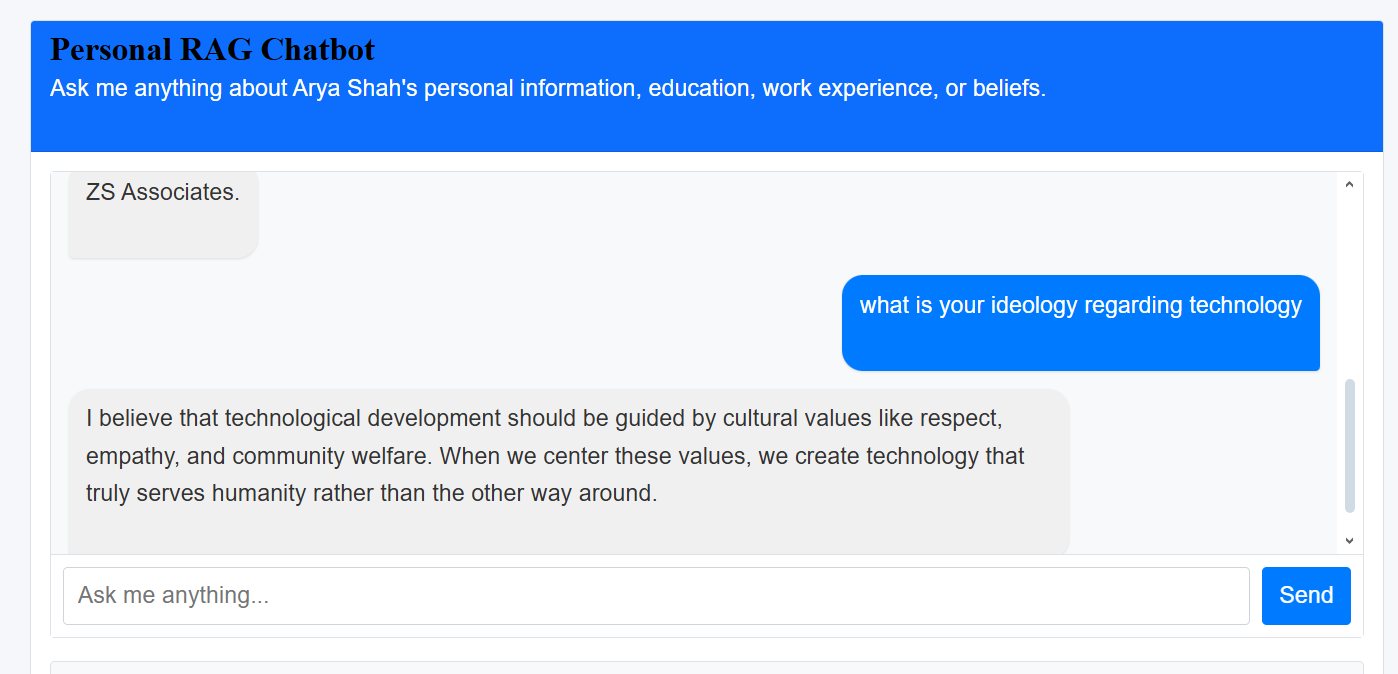

### Sources Gathered for Response:
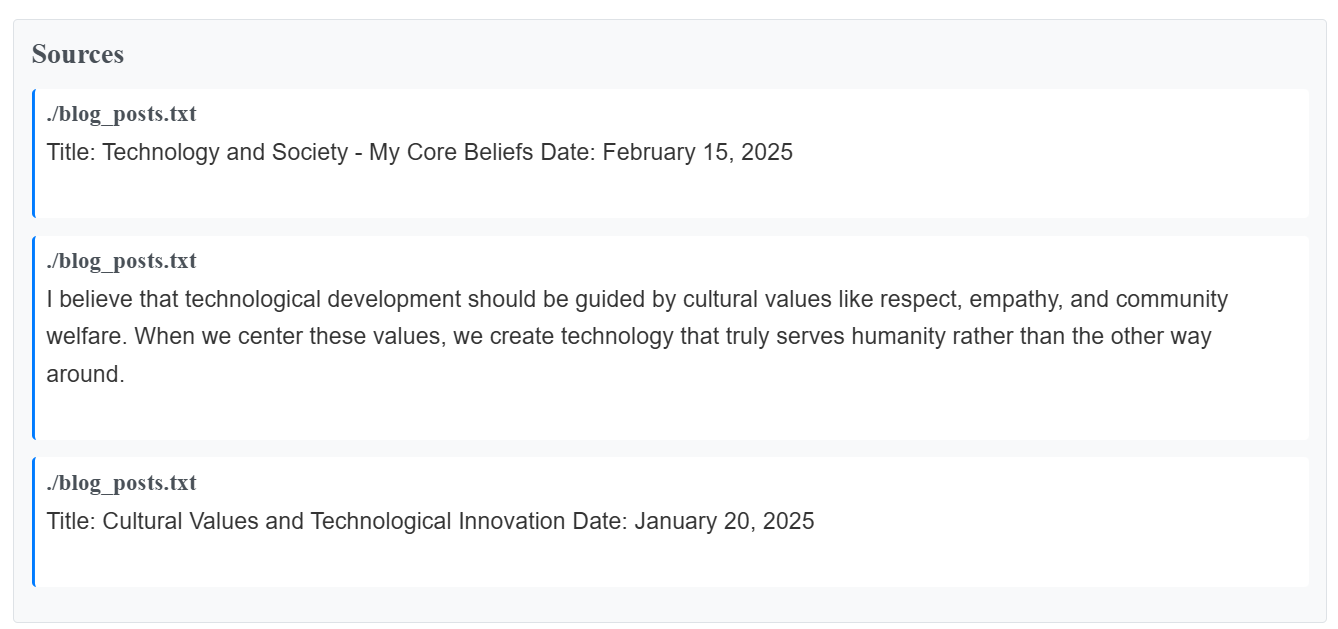

### Model Analysis Main Window

#### A. Retriever Model
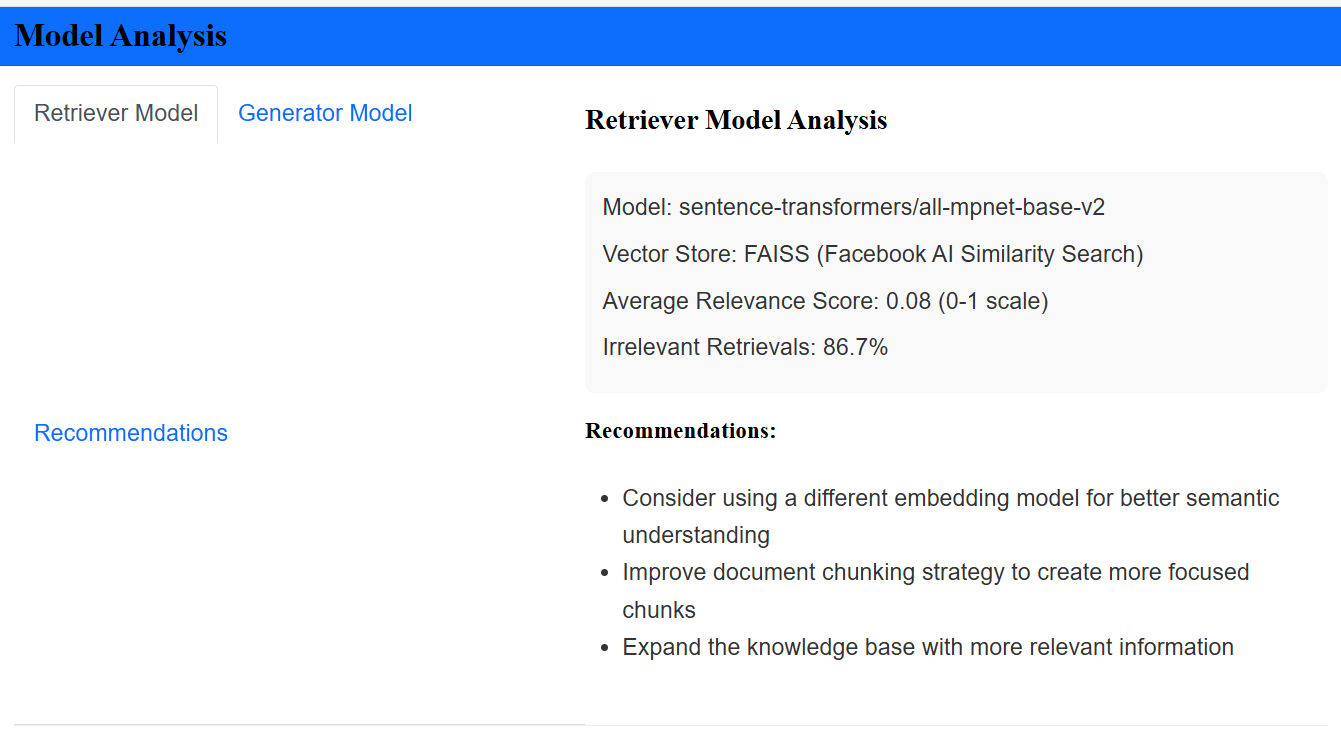

#### B. Generator Model
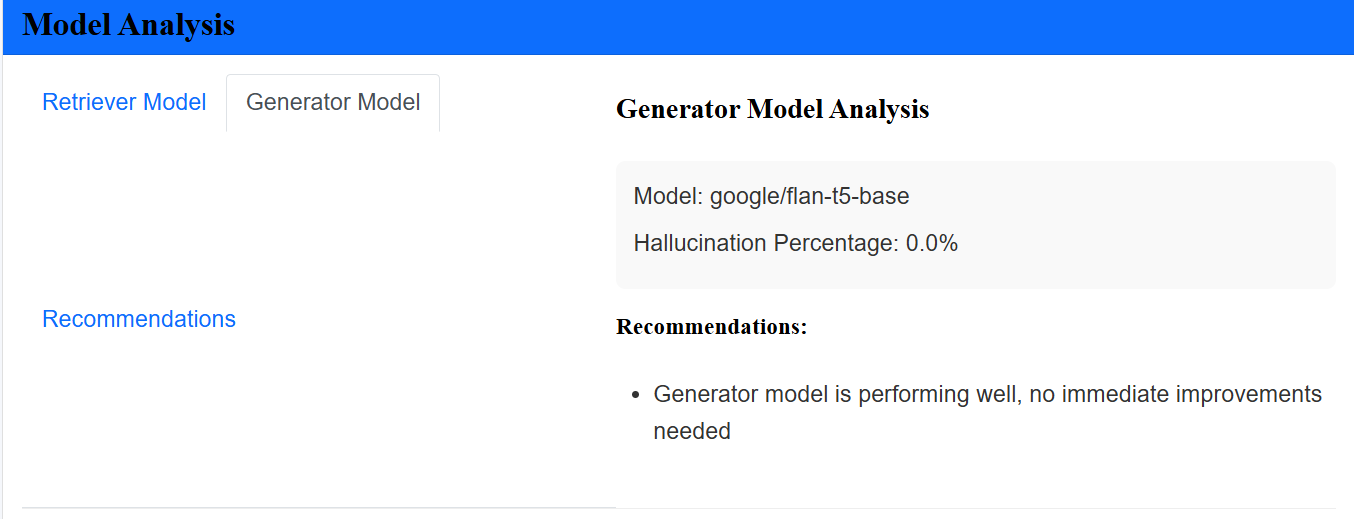

#### C. Recommendations
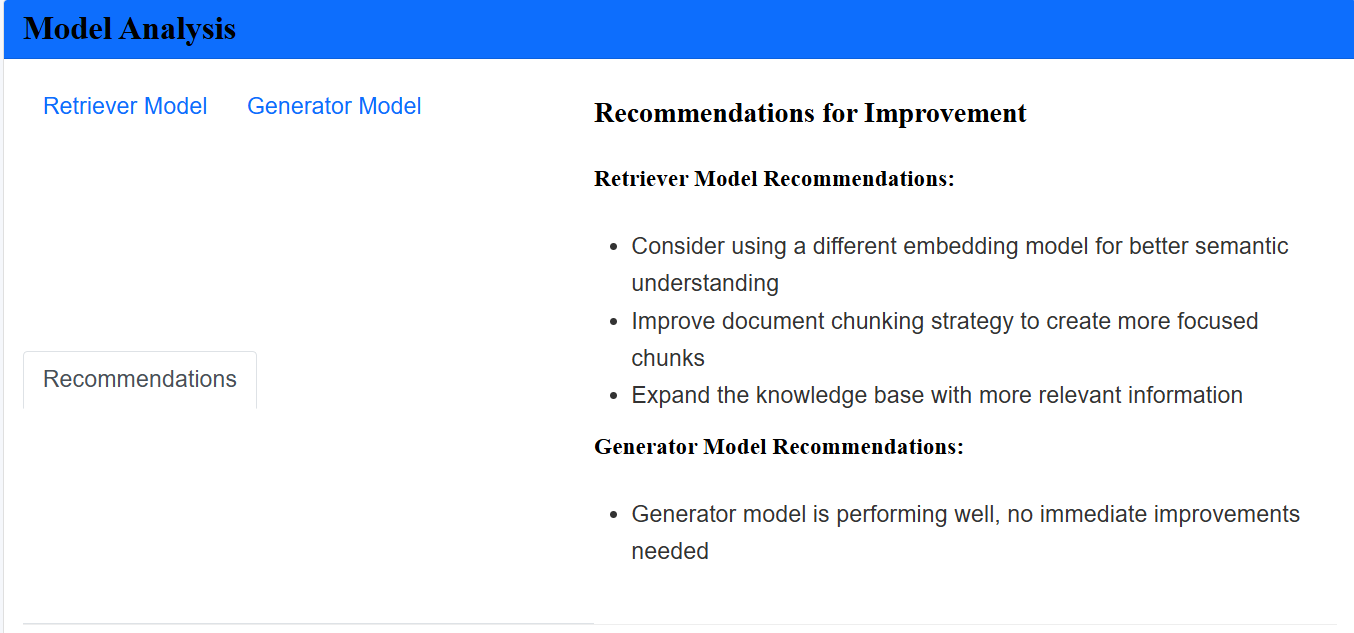

#### Analyze Your Questions
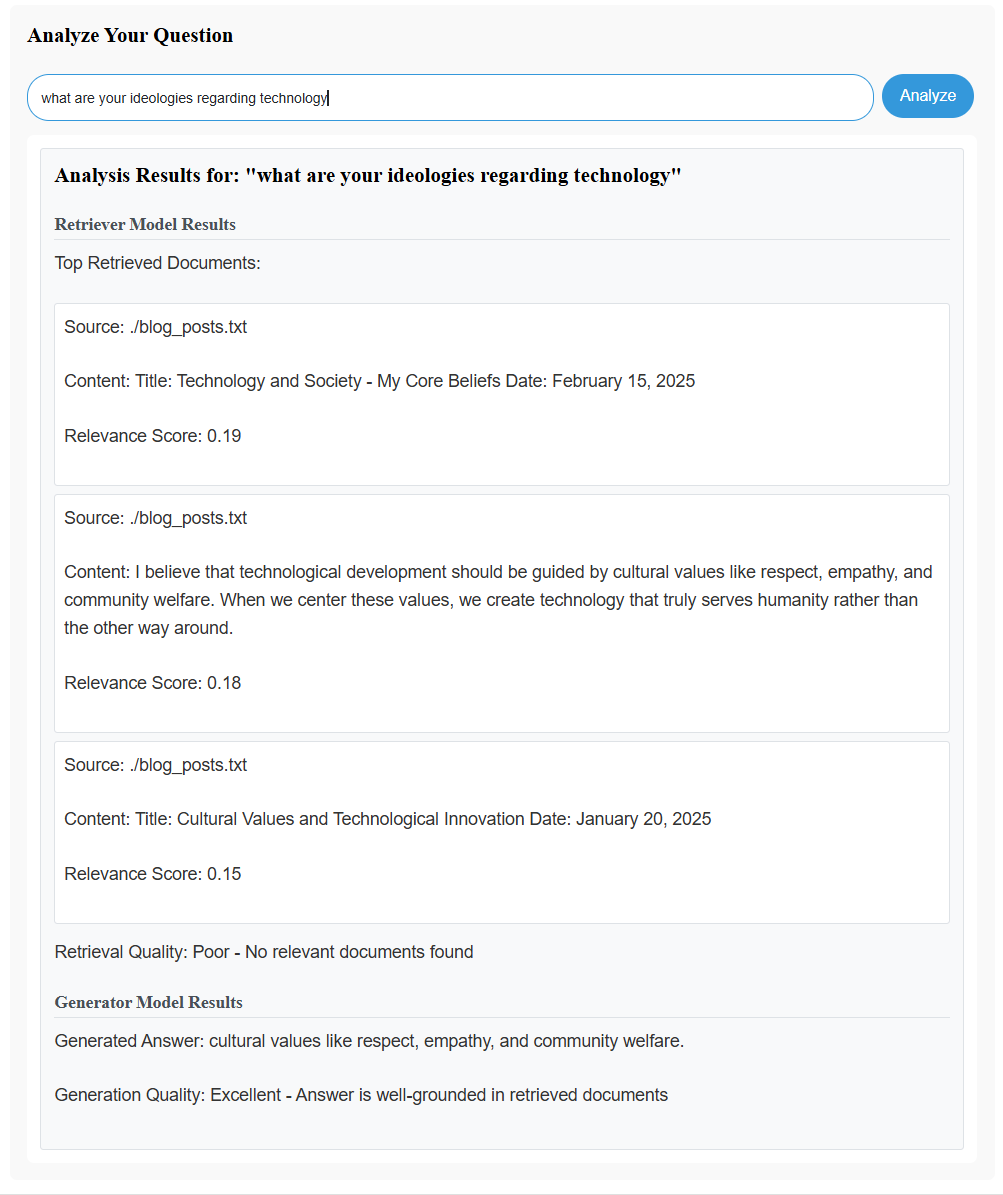

# Tests Conducted On The Final App

In [ ]:
import pytest
import json
from unittest.mock import patch, MagicMock

def test_a6_page(client):
    """Test that the A6 page loads successfully."""
    # Mock the initialize_rag_system and analysis functions
    with patch('app.core.routes.initialize_rag_system') as mock_init, \
         patch('app.core.routes.analyze_retriever_model') as mock_retriever, \
         patch('app.core.routes.analyze_generator_model') as mock_generator:
        
        # Configure mocks
        mock_rag = MagicMock()
        mock_init.return_value = mock_rag
        mock_retriever.return_value = {'performance': 'good'}
        mock_generator.return_value = {'performance': 'good'}
        
        # Test the route
        response = client.get('/a6')
        
        # Verify response
        assert response.status_code == 200
        assert b'Lets Talk Yourselves' in response.data
        assert b'Chat' in response.data
        assert b'Model Analysis' in response.data

def test_chat_missing_data(client):
    """Test error handling when no data is provided for chat."""
    response = client.post('/chat', 
                         data=json.dumps({}),
                         content_type='application/json')
    assert response.status_code == 400
    data = json.loads(response.data)
    assert 'error' in data

def test_chat_empty_message(client):
    """Test error handling when message is empty."""
    response = client.post('/chat', 
                         data=json.dumps({'message': ''}),
                         content_type='application/json')
    assert response.status_code == 400
    data = json.loads(response.data)
    assert 'error' in data
    assert 'No message provided' in data['error']

def test_chat_rag_not_initialized(client):
    """Test error handling when RAG system is not initialized."""
    # Ensure the RAG system is not initialized
    with patch('app.core.routes.models', {'a6': None}):
        response = client.post('/chat', 
                             data=json.dumps({'message': 'Hello'}),
                             content_type='application/json')
        assert response.status_code == 500
        data = json.loads(response.data)
        assert 'error' in data
        assert 'RAG system not initialized' in data['error']

def test_chat_valid_message(client):
    """Test chat with a valid message."""
    # Mock the RAG system and its query method
    mock_rag = MagicMock()
    mock_rag.query.return_value = {
        'question': 'Hello',
        'answer': 'Hi there!',
        'sources': [{'content': 'Greeting', 'source': 'test.txt'}]
    }
    
    with patch('app.core.routes.models', {'a6': mock_rag}), \
         patch('app.core.routes.qa_history', []), \
         patch('app.core.routes.open', MagicMock()), \
         patch('app.core.routes.json.dump', MagicMock()):
        
        response = client.post('/chat', 
                             data=json.dumps({'message': 'Hello'}),
                             content_type='application/json')
        
        assert response.status_code == 200
        data = json.loads(response.data)
        assert 'answer' in data
        assert data['answer'] == 'Hi there!'
        assert 'sources' in data
        assert len(data['sources']) == 1

def test_qa_history(client):
    """Test retrieving QA history."""
    # Mock the QA history
    test_history = [
        {'question': 'Hello', 'answer': 'Hi there!'},
        {'question': 'How are you?', 'answer': 'I am fine, thank you!'}
    ]
    
    with patch('app.core.routes.qa_history', test_history):
        response = client.get('/qa_history')
        
        assert response.status_code == 200
        data = json.loads(response.data)
        assert len(data) == 2
        assert data[0]['question'] == 'Hello'
        assert data[1]['answer'] == 'I am fine, thank you!'

def test_analyze_missing_data(client):
    """Test error handling when no data is provided for analysis."""
    response = client.post('/analyze', 
                         data=json.dumps({}),
                         content_type='application/json')
    assert response.status_code == 400
    data = json.loads(response.data)
    assert 'error' in data

def test_analyze_empty_question(client):
    """Test error handling when question is empty."""
    response = client.post('/analyze', 
                         data=json.dumps({'question': ''}),
                         content_type='application/json')
    assert response.status_code == 400
    data = json.loads(response.data)
    assert 'error' in data
    assert 'No question provided' in data['error']

def test_analyze_rag_not_initialized(client):
    """Test error handling when RAG system is not initialized for analysis."""
    # Ensure the RAG system is not initialized
    with patch('app.core.routes.models', {'a6': None}):
        response = client.post('/analyze', 
                             data=json.dumps({'question': 'What is RAG?'}),
                             content_type='application/json')
        assert response.status_code == 500
        data = json.loads(response.data)
        assert 'error' in data
        assert 'RAG system not initialized' in data['error']

def test_analyze_valid_question(client):
    """Test analysis with a valid question."""
    # Mock the RAG system, vector store, and query method
    mock_vector_store = MagicMock()
    mock_vector_store.similarity_search.return_value = [
        {'content': 'RAG stands for Retrieval-Augmented Generation', 'source': 'test.txt', 'score': 0.8}
    ]
    
    mock_rag = MagicMock()
    mock_rag.vector_store = mock_vector_store
    mock_rag.query.return_value = {
        'question': 'What is RAG?',
        'answer': 'RAG stands for Retrieval-Augmented Generation.',
        'sources': [{'content': 'RAG definition', 'source': 'test.txt'}]
    }
    
    with patch('app.core.routes.models', {'a6': mock_rag}):
        response = client.post('/analyze', 
                             data=json.dumps({'question': 'What is RAG?'}),
                             content_type='application/json')
        
        assert response.status_code == 200
        data = json.loads(response.data)
        assert 'retriever_results' in data
        assert 'generation_result' in data
        assert len(data['retriever_results']) == 1
        assert 'answer' in data['generation_result']
        assert 'sources' in data['generation_result']


```bash
(sandbox) D:\AIT Labs\Semester 2\NLP\A6\A6>pytest -v
================================================= test session starts =================================================
platform win32 -- Python 3.7.11, pytest-7.4.4, pluggy-1.2.0 -- D:\anaconda3\envs\sandbox\python.exe
cachedir: .pytest_cache
rootdir: D:\AIT Labs\Semester 2\NLP\A6\A6
plugins: anyio-3.7.1
collected 50 items

tests/test_a6.py::test_a6_page Windows fatal exception: code 0xc0000139
PASSED                                                                            [  2%]
tests/test_a6.py::test_chat_missing_data PASSED                                                                  [  4%]
tests/test_a6.py::test_chat_empty_message PASSED                                                                 [  6%]
tests/test_a6.py::test_chat_rag_not_initialized PASSED                                                           [  8%]
tests/test_a6.py::test_chat_valid_message PASSED                                                                 [ 10%]
tests/test_a6.py::test_qa_history PASSED                                                                         [ 12%]
tests/test_a6.py::test_analyze_missing_data PASSED                                                               [ 14%]
tests/test_a6.py::test_analyze_empty_question PASSED                                                             [ 16%]
tests/test_a6.py::test_analyze_rag_not_initialized PASSED                                                        [ 18%]
tests/test_a6.py::test_analyze_valid_question PASSED                                                             [ 20%]
tests/test_nli.py::test_nli_predictor_initialization PASSED                                                      [ 22%]
tests/test_nli.py::test_nli_tokenizer_vocabulary PASSED                                                          [ 24%]
tests/test_nli.py::test_nli_model_architecture PASSED                                                            [ 26%]
tests/test_nli.py::test_nli_prediction_format PASSED                                                             [ 28%]
tests/test_routes.py::test_home_page PASSED                                                                      [ 30%]
tests/test_routes.py::test_word_embeddings_page PASSED                                                           [ 32%]
tests/test_routes.py::test_coming_soon_page PASSED                                                               [ 34%]
tests/test_routes.py::test_find_similar_words_missing_data PASSED                                                [ 36%]
tests/test_routes.py::test_find_similar_words_missing_word PASSED                                                [ 38%]
tests/test_routes.py::test_find_similar_words_missing_model PASSED                                               [ 40%]
tests/test_routes.py::test_find_similar_words_invalid_model PASSED                                               [ 42%]
tests/test_routes.py::test_a2_page PASSED                                                                        [ 44%]
tests/test_routes.py::test_generate_text_missing_data PASSED                                                     [ 46%]
tests/test_routes.py::test_generate_text_missing_prompt PASSED                                                   [ 48%]
tests/test_routes.py::test_generate_text_invalid_temperature PASSED                                              [ 50%]
tests/test_routes.py::test_generate_text_invalid_max_length PASSED                                               [ 52%]
tests/test_routes.py::test_a3_page PASSED                                                                        [ 54%]
tests/test_routes.py::test_translate_missing_data PASSED                                                         [ 56%]
tests/test_routes.py::test_translate_missing_text PASSED                                                         [ 58%]
tests/test_routes.py::test_translate_missing_model PASSED                                                        [ 60%]
tests/test_routes.py::test_navigation_links PASSED                                                               [ 62%]
tests/test_routes.py::test_a4_page PASSED                                                                        [ 64%]
tests/test_routes.py::test_predict_nli_missing_data PASSED                                                       [ 66%]
tests/test_routes.py::test_predict_nli_missing_premise PASSED                                                    [ 68%]
tests/test_routes.py::test_predict_nli_missing_hypothesis PASSED                                                 [ 70%]
tests/test_routes.py::test_predict_nli_empty_inputs PASSED                                                       [ 72%]
tests/test_routes.py::test_predict_nli_valid_input PASSED                                                        [ 74%]
tests/test_routes.py::test_a5_page PASSED                                                                        [ 76%]
tests/test_routes.py::test_generate_dpo_response_missing_data PASSED                                             [ 78%]
tests/test_routes.py::test_generate_dpo_response_empty_prompt PASSED                                             [ 80%]
tests/test_routes.py::test_generate_dpo_response_valid_prompt PASSED                                             [ 82%]
tests/test_routes.py::test_api_a5_generate_missing_data PASSED                                                   [ 84%]
tests/test_routes.py::test_api_a5_generate_valid_prompt PASSED                                                   [ 86%]
tests/test_word_embeddings.py::test_load_model_file_not_found PASSED                                             [ 88%]
tests/test_word_embeddings.py::test_load_model_success PASSED                                                    [ 90%]
tests/test_word_embeddings.py::test_find_similar_words_invalid_word PASSED                                       [ 92%]
tests/test_word_embeddings.py::test_find_similar_words_valid_word PASSED                                         [ 94%]
tests/test_word_embeddings.py::test_find_similar_words_k_parameter PASSED                                        [ 96%]
tests/test_word_embeddings.py::test_embedding_dimensions PASSED                                                  [ 98%]
tests/test_word_embeddings.py::test_model_eval_mode PASSED                                                       [100%]

================================================== warnings summary ===================================================
..\..\..\..\..\anaconda3\envs\sandbox\lib\site-packages\flatbuffers\compat.py:19
  D:\anaconda3\envs\sandbox\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
    import imp

tests/test_nli.py::test_nli_prediction_format
tests/test_routes.py::test_predict_nli_valid_input
  D:\anaconda3\envs\sandbox\lib\site-packages\torch\amp\autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
    warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
===================================== 50 passed, 3 warnings in 440.70s (0:07:20) ======================================
```

## 10 Questions Your Chatbot Should Be Able to Answer ✅

Below are 10 questions your chatbot should be able to answer:

1. How old are you? ✅
2. What is your highest level of education? ✅
3. What major or field of study did you pursue during your education? ✅
4. How many years of work experience do you have? ✅
5. What type of work or industry have you been involved in? ✅
6. Can you describe your current role or job responsibilities? ✅
7. What are your core beliefs regarding the role of technology in shaping society? ✅
8. How do you think cultural values should influence technological advancements? ✅
9. As a master's student, what is the most challenging aspect of your studies so far? ✅
10. What specific research interests or academic goals do you hope to achieve during your time as a master's student? ✅

### Submission Instructions ✅

For each question, your chatbot should generate a response. Please submit the question-answer pairs to your Github repository in the following JSON format:

```json
[
  {
    "question": "How old are you?",
    "answer": "Your answer here"
  },
  {
    "question": "What is your highest level of education?",
    "answer": "Your answer here"
  },
  ...
]
```

Make sure that each question and corresponding answer is properly formatted in the JSON structure. This will be part of your deliverables. (0.5 point) ✅

# `JSON QA Generation Script`

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# Script to generate question-answer pairs in JSON format
import json
from simple_rag import initialize_rag_system

# List of required questions
questions = [
    "How old are you?",
    "What is your highest level of education?",
    "What major or field of study did you pursue during your education?",
    "How many years of work experience do you have?",
    "What type of work or industry have you been involved in?",
    "Can you describe your current role or job responsibilities?",
    "What are your core beliefs regarding the role of technology in shaping society?",
    "How do you think cultural values should influence technological advancements?",
    "As a master's student, what is the most challenging aspect of your studies so far?",
    "What specific research interests or academic goals do you hope to achieve during your time as a master's student?"
]

def generate_qa_json():
    print("Initializing RAG system...")
    rag_system = initialize_rag_system()
    print("RAG system initialized")
    
    qa_pairs = []
    
    print("\nGenerating answers for the required questions:")
    for i, question in enumerate(questions):
        print(f"Processing question {i+1}/10: {question}")
        result = rag_system.query(question)
        
        qa_pair = {
            "question": question,
            "answer": result["answer"]
        }
        qa_pairs.append(qa_pair)
    
    # Save to JSON file
    with open('qa_responses.json', 'w') as f:
        json.dump(qa_pairs, f, indent=2)
    
    print(f"\nGenerated answers for all {len(questions)} questions")
    print("Results saved to qa_responses.json")
    
    return qa_pairs

if __name__ == "__main__":
    generate_qa_json()


# JSON Response ✅

```json
[
  {
    "question": "How old are you?",
    "answer": "24 years old."
  },
  {
    "question": "What is your highest level of education?",
    "answer": "Master's degrees."
  },
  {
    "question": "What major or field of study did you pursue during your bachelor education?",
    "answer": "Computer Science."
  },
  {
    "question": "How many years of work experience do you have?",
    "answer": "2 years."
  },
  {
    "question": "What type of work or industry have you been involved in?",
    "answer": "technology industry."
  },
  {
    "question": "Can you describe your current role or job responsibilities?",
    "answer": "Associate Software Engineer (Full-time)"
  },
  {
    "question": "What are your core beliefs regarding the role of technology in shaping society?",
    "answer": "I believe that technological development should be guided by cultural values like respect, empathy, and community welfare."
  },
  {
    "question": "How do you think cultural values should influence technological advancements?",
    "answer": "We create technology that truly serves humanity rather than the other way around."
  },
  {
    "question": "As a master's student, what is the most challenging aspect of your studies so far?",
    "answer": "balancing the rigorous academic requirements across two programs simultaneously."
  },
  {
    "question": "What specific research interests or academic goals do you hope to achieve during your time as a master's student?",
    "answer": "natural language processing, deep learning applications, computer vision, and metaheuristic optimization."
  }
]
```

# Thank You! 🤗